In [1]:
## importing necessary libraries
import pandas as pd
import numpy as np
import json


In [2]:
df=pd.read_csv('chennai_cars - chennai_cars.csv.csv')
print(df.columns)

Index(['new_car_detail', 'new_car_overview', 'new_car_feature',
       'new_car_specs', 'car_links'],
      dtype='object')


In [3]:
print(df.head())

                                      new_car_detail  \
0  {'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...   
1  {'it': 0, 'ft': 'Petrol', 'bt': 'Minivans', 'k...   
2  {'it': 0, 'ft': 'Petrol', 'bt': 'SUV', 'km': '...   
3  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   
4  {'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...   

                                    new_car_overview  \
0  {'heading': 'Car overview', 'top': [{'key': 'R...   
1  {'heading': 'Car overview', 'top': [{'key': 'R...   
2  {'heading': 'Car overview', 'top': [{'key': 'R...   
3  {'heading': 'Car overview', 'top': [{'key': 'R...   
4  {'heading': 'Car overview', 'top': [{'key': 'R...   

                                     new_car_feature  \
0  {'heading': 'Features', 'top': [{'value': 'Pow...   
1  {'heading': 'Features', 'top': [{'value': 'Low...   
2  {'heading': 'Features', 'top': [{'value': 'Pow...   
3  {'heading': 'Features', 'top': [{'value': 'Pow...   
4  {'heading': 'Features', 'top': [{'value': '

# Converting unstructured format to structured format 

In [5]:
# Function to safely parse JSON strings
def safe_json_loads(json_str):
    if json_str is None:
        return {}  # Handle None case gracefully
    try:
        # Replace single quotes with double quotes and handle None
        json_str = json_str.replace("'", '"').replace('None', 'null')
        return json.loads(json_str)
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}  # Return an empty dict or handle as needed



In [6]:
# Function to process unstructured data
def process_city_data(data, city_name):
    structured_data = []
    
    for record in data:
        # Extract and parse the JSON strings safely
        detail = safe_json_loads(record.get('new_car_detail'))
        overview = safe_json_loads(record.get('new_car_overview'))
        features = safe_json_loads(record.get('new_car_feature'))
        specs = safe_json_loads(record.get('new_car_specs'))
        
        # Extract information from the parsed dictionaries
        city_info = {
            'model': detail.get('model'),
            'oem': detail.get('oem'),
            'modelYear': detail.get('modelYear'),
            'fuelType': detail.get('ft'),
            'bodyType': detail.get('bt'),
            'kmDriven': detail.get('km', '0').replace(',', ''),  # Handle None case
            'transmission': detail.get('transmission'),
            'ownerNo': detail.get('ownerNo'),
            'owner': detail.get('owner'),
            'price': detail.get('price'),
            'city': city_name,  # Add city name
            'trendingHeading': detail.get('trendingText', {}).get('heading'),
            'trendingDesc': detail.get('trendingText', {}).get('desc'),
            # Add other fields from overview, features, specs as needed
        }
         # Expand overview data into separate columns
        for item in overview.get('top', []):
            key = item['key'].lower().replace(' ', '_')  # Normalize key for column names
            city_info[key] = item['value']  # Add the value to city_info dict
            
        # Expand features data into separate columns
        for feature in features.get('top', []):
            feature_key = feature['value'].lower().replace(' ', '_').replace('&', 'and')  # Normalize key for column names
            city_info[feature_key] = True  # Add a boolean value indicating the feature is present
        # If there are more detailed specs in the 'data' section, extract those as well
        
        for category in specs.get('data', []):
            for spec in category.get('list', []):
                spec_key = spec['key'].lower().replace(' ', '_')  # Normalize key for column names
                city_info[spec_key] = spec['value']  # Add the value to city_info dict

        
        
        # Add additional details from overview, features, and specifications
        structured_data.append({**city_info, 
                                'overview': overview.get('top', []), 
                                'features': features.get('top', []), 
                                'specifications': specs.get('top', [])})

    return structured_data


In [7]:
# List of city CSV files
city_files = ['bangalore_cars - bangalore_cars.csv.csv', 
              'chennai_cars - chennai_cars.csv.csv', 
              'delhi_cars - delhi_cars.csv.csv', 
              'hyderabad_cars - hyderabad_cars.csv.csv', 
              'jaipur_cars - jaipur_cars.csv.csv', 
              'kolkata_cars - kolkata_cars.csv.csv']

# Dictionary to hold processed data for all cities
all_structured_data = []

In [8]:
for city_file in city_files:
    city_name = city_file.split('.')[0]  # Get the city name from the filename

    # Load the CSV file
    df = pd.read_csv(city_file)
    df.columns = df.columns.str.strip()  # Strip any whitespace from column names

    # Convert DataFrame to list of dictionaries
    city_data = df.to_dict(orient='records')

    # Process the data for the city
    processed_data = process_city_data(city_data, city_name)

    # Extend the main structured data list
    all_structured_data.extend(processed_data)

# Convert the structured data to a DataFrame
final_dataframe = pd.DataFrame(all_structured_data)

# Display the final structured DataFrame
print(final_dataframe.head())

                model      oem  modelYear fuelType   bodyType kmDriven  \
0      Maruti Celerio   Maruti       2015   Petrol  Hatchback   120000   
1       Ford Ecosport     Ford       2018   Petrol        SUV    32706   
2          Tata Tiago     Tata       2018   Petrol  Hatchback    11949   
3       Hyundai Xcent  Hyundai       2014   Petrol      Sedan    17794   
4  Maruti SX4 S Cross   Maruti       2015   Diesel        SUV    60000   

  transmission  ownerNo      owner        price  ... cruise_control  \
0       Manual        3  3rd Owner     ₹ 4 Lakh  ...            NaN   
1       Manual        2  2nd Owner  ₹ 8.11 Lakh  ...            NaN   
2       Manual        1  1st Owner  ₹ 5.85 Lakh  ...            NaN   
3       Manual        1  1st Owner  ₹ 4.62 Lakh  ...            NaN   
4       Manual        1  1st Owner  ₹ 7.90 Lakh  ...            NaN   

  drive_modes digital_clock passenger_air_bag rear_folding_table  \
0         NaN           NaN               NaN               

In [9]:
final_dataframe.drop(columns=['overview','features'],inplace=True)

# Exploring the data

In [11]:
final_dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Columns: 133 entries, model to leddrls
dtypes: float64(3), int64(2), object(128)
memory usage: 8.5+ MB


In [12]:
final_dataframe.dtypes

model                             object
oem                               object
modelYear                          int64
fuelType                          object
bodyType                          object
                                   ...  
driving_experience_control_eco    object
engine_immobilizer                object
rear_spoiler                      object
alloy_wheels                      object
leddrls                           object
Length: 133, dtype: object

In [13]:
final_dataframe.describe()

,modelYear,ownerNo,year_of_manufacture,no_of_cylinder,values_per_cylinder
count,8369.000000,8369.000000,8349.000000,8338.000000,8318.000000
mean,2016.503286,1.360139,2016.547850,3.802471,3.934359
std,3.921465,0.641958,3.811882,0.594613,0.792698
min,1985.000000,0.000000,2002.000000,2.000000,2.000000
25%,2014.000000,1.000000,2014.000000,4.000000,4.000000
50%,2017.000000,1.000000,2017.000000,4.000000,4.000000
75%,2019.000000,2.000000,2019.000000,4.000000,4.000000
max,2023.000000,5.000000,2023.000000,23.000000,69.000000


In [14]:
final_dataframe.isnull().sum()

model                                0
oem                                  0
modelYear                            0
fuelType                             0
bodyType                             0
                                  ... 
driving_experience_control_eco    8368
engine_immobilizer                8368
rear_spoiler                      8368
alloy_wheels                      8367
leddrls                           8367
Length: 133, dtype: int64

# Preprocessing

In [16]:
# Identify identical columns using a try-except to handle unhashable types
identical_cols = []

for col in final_dataframe.columns:
    try:
        if final_dataframe[col].nunique() == 1:
            identical_cols.append(col)
    except TypeError:
        # Handle columns with unhashable types
        if final_dataframe[col].apply(lambda x: str(x)).nunique() == 1:
            identical_cols.append(col)

# Drop the identical columns
final_dataframe = final_dataframe.drop(columns=identical_cols)

print("Identical columns:", identical_cols)

Identical columns: ['trendingHeading', 'trendingDesc', 'power_steering', 'power_windows_front', 'air_conditioner', 'heater', 'adjustable_head_lights', 'manually_adjustable_exterior_rear_view_mirror', 'centeral_locking', 'child_safety_locks', 'fog_lights_front', 'anti_lock_braking_system', 'cd_player', 'radio', 'power_adjustable_exterior_rear_view_mirror', 'brake_assist', 'electric_folding_rear_view_mirror', 'power_door_locks', 'cd_changer', 'fog_lights_rear', 'remote_trunk_opener', 'tinted_glass', 'halogen_headlamps', 'usb_auxiliary_input', 'passenger_side_rear_view_mirror', 'cassette_player', 'day_night_rear_view_mirror', 'power_windows_rear', 'leather_seats', 'leather_steering_wheel', 'rear_seat_belts', 'remote_fuel_lid_opener', 'bluetooth', 'speakers_front', 'power_antenna', 'dvd_player', 'audio_system_remote_control', 'wheel_covers', 'rear_window_wiper', 'driver_air_bag', 'low_fuel_warning_light', 'cup_holders_front', 'navigation_system', 'tachometer', 'glove_compartment', 'integra

In [17]:
num_columns = len(identical_cols)

print("Number of identical columns:", num_columns)

Number of identical columns: 77


In [18]:
final_dataframe.head(2)

,model,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,owner,price,...,front_brake_type,rear_brake_type,top_speed,acceleration,tyre_type,no_door_numbers,cargo_volumn,specifications,alloy_wheel_size,ground_clearance_unladen
0,Maruti Celerio,Maruti,2015,Petrol,Hatchback,120000,Manual,3,3rd Owner,₹ 4 Lakh,...,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5,235-litres,"[{'key': 'Mileage', 'value': '23.1 kmpl'}, {'k...",NaN,NaN
1,Ford Ecosport,Ford,2018,Petrol,SUV,32706,Manual,2,2nd Owner,₹ 8.11 Lakh,...,Ventilated Disc,Drum,NaN,NaN,"Tubeless,Radial",4,352-litres,"[{'key': 'Mileage', 'value': '17 kmpl'}, {'key...",16,NaN


In [19]:
final_dataframe['specifications'].value_counts()

specifications
[{'key': 'Mileage', 'value': '21.4 kmpl'}, {'key': 'Engine', 'value': '1197 CC'}, {'key': 'Max Power', 'value': '83.1bhp'}, {'key': 'Torque', 'value': '115Nm'}, {'key': 'Wheel Size', 'value': '16'}, {'key': 'Seats', 'value': '5'}]       118
[{'key': 'Mileage', 'value': '22.38 kmpl'}, {'key': 'Engine', 'value': '1197 CC'}, {'key': 'Max Power', 'value': '88.50bhp'}, {'key': 'Torque', 'value': '113Nm'}, {'key': 'Seats', 'value': '5'}]                                           112
[{'key': 'Mileage', 'value': '22.05 kmpl'}, {'key': 'Engine', 'value': '796 CC'}, {'key': 'Max Power', 'value': '47.33bhp'}, {'key': 'Torque', 'value': '69Nm'}, {'key': 'Seats', 'value': '5'}]                                              96
[{'key': 'Mileage', 'value': '18.9 kmpl'}, {'key': 'Engine', 'value': '1197 CC'}, {'key': 'Max Power', 'value': '81.86bhp'}, {'key': 'Torque', 'value': '113.75nm'}, {'key': 'Seats', 'value': '5'}]                                          82
[{'key': 'Mileage', '

In [20]:
# Function to extract specification key value 
def extract_spec_value(specifications, key):
    # Loop through the list of dictionaries to find the matching key and return its value
    for spec in specifications:
        if spec['key'].lower() == key.lower():
            return spec['value']
    return None  # Return None if the key isn't found

# Now, extract 'Mileage', 'Engine', 'Max Power', and 'Cargo Volumn' from the 'specifications' column
final_dataframe['mileage'] = final_dataframe['specifications'].apply(lambda x: extract_spec_value(x, 'Mileage'))
final_dataframe['engine_capacity'] = final_dataframe['specifications'].apply(lambda x: extract_spec_value(x, 'Engine'))
final_dataframe['max_power'] = final_dataframe['specifications'].apply(lambda x: extract_spec_value(x, 'Max Power'))
final_dataframe['cargo_volumn'] = final_dataframe['specifications'].apply(lambda x: extract_spec_value(x, 'Cargo Volumn'))

# Check the result
final_dataframe[['mileage', 'engine_capacity', 'max_power', 'cargo_volumn']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   mileage          8082 non-null   object
 1   engine_capacity  8365 non-null   object
 2   max_power        8309 non-null   object
 3   cargo_volumn     0 non-null      object
dtypes: object(4)
memory usage: 261.7+ KB


In [21]:
final_dataframe.head()

,model,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,owner,price,...,top_speed,acceleration,tyre_type,no_door_numbers,cargo_volumn,specifications,alloy_wheel_size,ground_clearance_unladen,mileage,engine_capacity
0,Maruti Celerio,Maruti,2015,Petrol,Hatchback,120000,Manual,3,3rd Owner,₹ 4 Lakh,...,150 Kmph,15.05 Seconds,"Tubeless, Radial",5,None,"[{'key': 'Mileage', 'value': '23.1 kmpl'}, {'k...",NaN,NaN,23.1 kmpl,998 CC
1,Ford Ecosport,Ford,2018,Petrol,SUV,32706,Manual,2,2nd Owner,₹ 8.11 Lakh,...,NaN,NaN,"Tubeless,Radial",4,None,"[{'key': 'Mileage', 'value': '17 kmpl'}, {'key...",16,NaN,17 kmpl,1497 CC
2,Tata Tiago,Tata,2018,Petrol,Hatchback,11949,Manual,1,1st Owner,₹ 5.85 Lakh,...,150 kmph,14.3 Seconds,Tubeless,5,None,"[{'key': 'Mileage', 'value': '23.84 kmpl'}, {'...",14,NaN,23.84 kmpl,1199 CC
3,Hyundai Xcent,Hyundai,2014,Petrol,Sedan,17794,Manual,1,1st Owner,₹ 4.62 Lakh,...,172km/hr,14.2 Seconds,"Tubeless,Radial",4,None,"[{'key': 'Mileage', 'value': '19.1 kmpl'}, {'k...",14,NaN,19.1 kmpl,1197 CC
4,Maruti SX4 S Cross,Maruti,2015,Diesel,SUV,60000,Manual,1,1st Owner,₹ 7.90 Lakh,...,190 Kmph,12 Seconds,"Tubeless,Radial",5,None,"[{'key': 'Mileage', 'value': '23.65 kmpl'}, {'...",16,NaN,23.65 kmpl,1248 CC


In [22]:
final_dataframe_1=final_dataframe.copy()
final_dataframe_1.to_csv('city_details')

In [23]:
def clean_column(dataframe, column_name, unit_removal_chars=None, conversion_type=float):
    if unit_removal_chars:
        # Remove specified characters (like 'Kg', 'Kms', 'Lakh', etc.)
        dataframe[column_name] = dataframe[column_name].replace(unit_removal_chars, '', regex=True)
    
    # Convert to numeric, handling errors by coercing invalid parsing to NaN
    dataframe[column_name] = pd.to_numeric(dataframe[column_name], errors='coerce')
    
    return dataframe

# List of columns to clean and convert
columns_to_clean = {
    'kmDriven': ['Kms'], 
    'price': ['₹', ' Lakh'],  
    'kms_driven': ['Kms'],  
    'kerb_weight': ['Kg'],
    'gross_weight': ['Kg'],
    'top_speed': [' kmph'],
    'acceleration': [' Seconds'],
    'length': ['mm'],
    'width': ['mm'],
    'height': ['mm'],
    'wheel_base': ['mm'],
    'turning_radius': ['m'],
}

In [24]:
# Clean each specified column
for column, chars in columns_to_clean.items():
    final_dataframe = clean_column(final_dataframe, column, chars)
final_dataframe.drop(columns=['owner', 'ownership', 'engine_displacement','kms_driven'], inplace=True)



In [25]:
# Clean to retain only numeric values
final_dataframe['registration_year'] = final_dataframe['registration_year'].replace('[^0-9]', '', regex=True)
final_dataframe['registration_year'] = pd.to_numeric(final_dataframe['registration_year'], errors='coerce')
final_dataframe['seats'] = final_dataframe['seats'].replace('[^0-9]', '', regex=True)
final_dataframe['seats'] = pd.to_numeric(final_dataframe['seats'], errors='coerce')
final_dataframe['engine_type'] = final_dataframe['engine_type'].str.replace('Engine', '', regex=False, case=False)
final_dataframe['displacement'] = pd.to_numeric(final_dataframe['displacement'], errors='coerce')
final_dataframe['ground_clearance_unladen'] = final_dataframe['ground_clearance_unladen'].str.replace('mm', '', regex=False, case=False)
final_dataframe['cargo_volumn'] = final_dataframe['cargo_volumn'].replace('[^0-9]', '', regex=True)

In [26]:
# Update 'city' column based on specified patterns
city_mapping = {
    'bangalore_cars - bangalore_cars': 'bangalore',
    'delhi_cars - delhi_cars': 'delhi',
    'jaipur_cars - jaipur_cars': 'jaipur',
    'kolkata_cars - kolkata_cars': 'kolkata',
    'hyderabad_cars - hyderabad_cars': 'hyderabad',
    'chennai_cars - chennai_cars': 'chennai'
}
final_dataframe['city'] = final_dataframe['city'].replace(city_mapping)

In [27]:
i = 349

# Set the option to display all columns
pd.set_option('display.max_columns', None)  # Show all columns

# Display the specified row
print(final_dataframe.iloc[i])

model                                                        Volkswagen Vento
oem                                                                Volkswagen
modelYear                                                                2011
fuelType                                                               Diesel
bodyType                                                                Sedan
kmDriven                                                                90000
transmission                                                           Manual
ownerNo                                                                     4
price                                                                    2.19
city                                                                bangalore
registration_year                                                      2011.0
insurance_validity                                      Third Party insurance
fuel_type                                                       

In [28]:
# Dropping features with high missing values
final_dataframe.drop(columns=['gross_weight', 'compression_ratio', 'turning_radius', 'top_speed', 'borex_stroke', 'super_charger','fuel_type'], inplace=True)

In [29]:
final_dataframe.head()

,model,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,price,city,registration_year,insurance_validity,seats,rto,year_of_manufacture,color,engine_type,displacement,max_power,max_torque,no_of_cylinder,values_per_cylinder,value_configuration,fuel_suppy_system,turbo_charger,length,width,height,wheel_base,front_tread,rear_tread,kerb_weight,gear_box,drive_type,seating_capacity,steering_type,front_brake_type,rear_brake_type,acceleration,tyre_type,no_door_numbers,cargo_volumn,specifications,alloy_wheel_size,ground_clearance_unladen,mileage,engine_capacity
0,Maruti Celerio,Maruti,2015,Petrol,Hatchback,120000,Manual,3,4.00,bangalore,2015.0,Third Party insurance,5.0,KA51,2015.0,White,K10B,998.0,67.04bhp,90Nm@3500rpm,3.0,4.0,DOHC,MPFi,No,3715.0,1635.0,1565.0,2425.0,1420mm,1410mm,NaN,5 Speed,FWD,5,Power,Ventilated Disc,Drum,15.05,"Tubeless, Radial",5,None,"[{'key': 'Mileage', 'value': '23.1 kmpl'}, {'k...",NaN,NaN,23.1 kmpl,998 CC
1,Ford Ecosport,Ford,2018,Petrol,SUV,32706,Manual,2,8.11,bangalore,2018.0,Comprehensive,5.0,KA05,2018.0,White,Ti-VCT Petrol,1497.0,121.31bhp,150Nm@4500rpm,3.0,4.0,DOHC,Direct Injection,No,3998.0,1765.0,1647.0,2519.0,NaN,NaN,1242.0,5 Speed,FWD,5,Power,Ventilated Disc,Drum,NaN,"Tubeless,Radial",4,None,"[{'key': 'Mileage', 'value': '17 kmpl'}, {'key...",16,NaN,17 kmpl,1497 CC
2,Tata Tiago,Tata,2018,Petrol,Hatchback,11949,Manual,1,5.85,bangalore,2018.0,Comprehensive,5.0,KA03,2018.0,Red,Revotron,1199.0,84bhp,114Nm@3500rpm,3.0,4.0,DOHC,MPFi,No,3746.0,1647.0,1535.0,2400.0,1400mm,1420mm,NaN,5 Speed,FWD,5,Power,Disc,Drum,14.30,Tubeless,5,None,"[{'key': 'Mileage', 'value': '23.84 kmpl'}, {'...",14,NaN,23.84 kmpl,1199 CC
3,Hyundai Xcent,Hyundai,2014,Petrol,Sedan,17794,Manual,1,4.62,bangalore,2014.0,Comprehensive,5.0,KA53,2014.0,Others,Kappa VTVT Petrol,1197.0,81.86bhp,113.75Nm@4000rpm,4.0,4.0,DOHC,Direct Injection,No,3995.0,1660.0,1520.0,2425.0,1479mm,1493mm,1180.0,5 Speed,FWD,5,Power,Disc,Drum,14.20,"Tubeless,Radial",4,None,"[{'key': 'Mileage', 'value': '19.1 kmpl'}, {'k...",14,NaN,19.1 kmpl,1197 CC
4,Maruti SX4 S Cross,Maruti,2015,Diesel,SUV,60000,Manual,1,7.90,bangalore,2015.0,Third Party insurance,5.0,KA04,2015.0,Gray,DDiS 200 Diesel,1248.0,88.5bhp,200Nm@1750rpm,4.0,4.0,DOHC,NaN,Yes,4300.0,1785.0,1595.0,2600.0,NaN,NaN,1230.0,5 Speed,FWD,5,Power,Ventilated Disc,Solid Disc,12.00,"Tubeless,Radial",5,None,"[{'key': 'Mileage', 'value': '23.65 kmpl'}, {'...",16,NaN,23.65 kmpl,1248 CC


In [30]:
features_to_drop = ['rto','model', 'color', 'value_configuration','fuel_suppy_system','registration_year','seats','gear_box','length','height','width',
                    'turbo_charger', 'front_brake_type', 'rear_brake_type', 'steering_type','ground_clearance_unladen','kerb_weight','alloy_wheel_size',
                    'tyre_type', 'cargo_volumn','fuel_suppy_system','turbo_charger','rear_tread','front_tread','acceleration','specifications','wheel_base',
                    'drive_type','no_door_numbers','steering_type','front_brake_type','rear_brake_type','values_per_cylinder','max_torque','engine_type']

final_dataframe = final_dataframe.drop(columns=features_to_drop)


In [31]:
# Remove unwanted text and convert to float
final_dataframe['mileage'] = final_dataframe['mileage'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
final_dataframe['engine_capacity'] = final_dataframe['engine_capacity'].str.replace(r'[^\d.]+', '', regex=True).astype(float)
final_dataframe['max_power'] = final_dataframe['max_power'].str.replace(r'[^\d.]+', '', regex=True).astype(float)

In [32]:
final_dataframe.head()

,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,price,city,insurance_validity,year_of_manufacture,displacement,max_power,no_of_cylinder,seating_capacity,mileage,engine_capacity
0,Maruti,2015,Petrol,Hatchback,120000,Manual,3,4.00,bangalore,Third Party insurance,2015.0,998.0,67.04,3.0,5,23.10,998.0
1,Ford,2018,Petrol,SUV,32706,Manual,2,8.11,bangalore,Comprehensive,2018.0,1497.0,121.31,3.0,5,17.00,1497.0
2,Tata,2018,Petrol,Hatchback,11949,Manual,1,5.85,bangalore,Comprehensive,2018.0,1199.0,84.00,3.0,5,23.84,1199.0
3,Hyundai,2014,Petrol,Sedan,17794,Manual,1,4.62,bangalore,Comprehensive,2014.0,1197.0,81.86,4.0,5,19.10,1197.0
4,Maruti,2015,Diesel,SUV,60000,Manual,1,7.90,bangalore,Third Party insurance,2015.0,1248.0,88.50,4.0,5,23.65,1248.0


In [33]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oem                  8369 non-null   object 
 1   modelYear            8369 non-null   int64  
 2   fuelType             8369 non-null   object 
 3   bodyType             8369 non-null   object 
 4   kmDriven             8369 non-null   int64  
 5   transmission         8369 non-null   object 
 6   ownerNo              8369 non-null   int64  
 7   price                8239 non-null   float64
 8   city                 8369 non-null   object 
 9   insurance_validity   8365 non-null   object 
 10  year_of_manufacture  8349 non-null   float64
 11  displacement         8365 non-null   float64
 12  max_power            8309 non-null   float64
 13  no_of_cylinder       8338 non-null   float64
 14  seating_capacity     8363 non-null   object 
 15  mileage              8082 non-null   f

In [34]:
# convert object columns to numerical
final_dataframe['seating_capacity'] = pd.to_numeric(final_dataframe['seating_capacity'], errors='coerce')
# Check the data types after conversion
print(final_dataframe.dtypes)



oem                     object
modelYear                int64
fuelType                object
bodyType                object
kmDriven                 int64
transmission            object
ownerNo                  int64
price                  float64
city                    object
insurance_validity      object
year_of_manufacture    float64
displacement           float64
max_power              float64
no_of_cylinder         float64
seating_capacity       float64
mileage                float64
engine_capacity        float64
dtype: object


In [35]:
final_dataframe.isnull().sum()

oem                      0
modelYear                0
fuelType                 0
bodyType                 0
kmDriven                 0
transmission             0
ownerNo                  0
price                  130
city                     0
insurance_validity       4
year_of_manufacture     20
displacement             4
max_power               60
no_of_cylinder          31
seating_capacity         6
mileage                287
engine_capacity          4
dtype: int64

In [36]:
final_dataframe['price'] = final_dataframe['price'].fillna(final_dataframe['price'].median())
final_dataframe['year_of_manufacture'] = final_dataframe['year_of_manufacture'].fillna(final_dataframe['year_of_manufacture'].median())
final_dataframe['displacement'] = final_dataframe['displacement'].fillna(final_dataframe['displacement'].median())
final_dataframe['insurance_validity'] = final_dataframe['insurance_validity'].fillna(final_dataframe['insurance_validity'].mode()[0])
final_dataframe['engine_capacity'] = final_dataframe['engine_capacity'].fillna(final_dataframe['engine_capacity'].mode()[0])
final_dataframe['seating_capacity'] = final_dataframe['seating_capacity'].fillna(final_dataframe['seating_capacity'].mode()[0])


In [37]:
# Handle missing values for 'mileage'
if final_dataframe['mileage'].skew() > 1:  # If highly skewed (positively skewed in this case)
    final_dataframe['mileage'] = final_dataframe['mileage'].fillna(final_dataframe['mileage'].median())
else:  # If not skewed, you can use mean
    final_dataframe['mileage'] = final_dataframe['mileage'].fillna(final_dataframe['mileage'].mean())


In [38]:
# Handle missing values for 'max_power'
if final_dataframe['max_power'].skew() > 1:  # If highly skewed
    final_dataframe['max_power'] = final_dataframe['max_power'].fillna(final_dataframe['max_power'].median())
else:  # If not skewed, you can use mean
    final_dataframe['max_power'] = final_dataframe['max_power'].fillna(final_dataframe['max_power'].mean())

In [39]:
# Handle missing values for 'no_of_cylinder' (use mode as it's categorical)
final_dataframe['no_of_cylinder'] = final_dataframe['no_of_cylinder'].fillna(final_dataframe['no_of_cylinder'].mode()[0])


In [40]:
final_dataframe.isnull().sum()

oem                    0
modelYear              0
fuelType               0
bodyType               0
kmDriven               0
transmission           0
ownerNo                0
price                  0
city                   0
insurance_validity     0
year_of_manufacture    0
displacement           0
max_power              0
no_of_cylinder         0
seating_capacity       0
mileage                0
engine_capacity        0
dtype: int64

# Label Encoding the features 

In [42]:
final_dataframe['oem'].unique()

array(['Maruti', 'Ford', 'Tata', 'Hyundai', 'Jeep', 'Datsun', 'Honda',
       'Mahindra', 'Mercedes-Benz', 'BMW', 'Renault', 'Audi', 'Toyota',
       'Mini', 'Kia', 'Skoda', 'Volkswagen', 'Volvo', 'MG', 'Nissan',
       'Fiat', 'Mahindra Ssangyong', 'Mitsubishi', 'Jaguar', 'Land Rover',
       'Chevrolet', 'Citroen', 'Opel', 'Mahindra Renault', 'Isuzu',
       'Lexus', 'Porsche', 'Hindustan Motors'], dtype=object)

In [43]:
### Replacing 'oem' values with ascending numbers
final_dataframe['oem'].replace(['Maruti', 'Ford', 'Tata', 'Hyundai', 'Jeep', 'Datsun', 'Honda',
                                'Mahindra', 'Mercedes-Benz', 'BMW', 'Renault', 'Audi', 'Toyota',
                                'Mini', 'Kia', 'Skoda', 'Volkswagen', 'Volvo', 'MG', 'Nissan',
                                'Fiat', 'Mahindra Ssangyong', 'Mitsubishi', 'Jaguar', 'Land Rover',
                                'Chevrolet', 'Citroen', 'Opel', 'Mahindra Renault', 'Isuzu',
                                'Lexus', 'Porsche', 'Hindustan Motors'],
                               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,31,32], inplace=True)


C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\3854667428.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataframe['oem'].replace(['Maruti', 'Ford', 'Tata', 'Hyundai', 'Jeep', 'Datsun', 'Honda',
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\3854667428.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_d

In [44]:
final_dataframe['fuelType'].unique()

array(['Petrol', 'Diesel', 'Lpg', 'Cng', 'Electric'], dtype=object)

In [45]:
# Replacing 'fuelType' values with numbers starting from 0
final_dataframe['fuelType'].replace(['Petrol', 'Diesel', 'Lpg', 'Cng', 'Electric'], [0, 1, 2, 3, 4], inplace=True)


C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\853649357.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataframe['fuelType'].replace(['Petrol', 'Diesel', 'Lpg', 'Cng', 'Electric'], [0, 1, 2, 3, 4], inplace=True)
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\853649357.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('f

In [46]:
final_dataframe['bodyType'].unique()

array(['Hatchback', 'SUV', 'Sedan', 'MUV', 'Coupe', 'Minivans',
       'Pickup Trucks', 'Convertibles', 'Hybrids', '', 'Wagon'],
      dtype=object)

In [47]:
# Replace missing or empty values with -1 and then perform label encoding
final_dataframe['bodyType'].replace(['Hatchback', 'SUV', 'Sedan', 'MUV', 'Coupe', 'Minivans',
                                     'Pickup Trucks', 'Convertibles', 'Hybrids', 'Wagon', ''], 
                                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1], inplace=True)


C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\132414816.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataframe['bodyType'].replace(['Hatchback', 'SUV', 'Sedan', 'MUV', 'Coupe', 'Minivans',
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\132414816.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downc

In [48]:
final_dataframe['transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [49]:
# Replace 'Manual' with 0 and 'Automatic' with 1 in the 'transmission' column
final_dataframe['transmission'].replace(['Manual', 'Automatic'], [0, 1], inplace=True)


C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\3435566557.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataframe['transmission'].replace(['Manual', 'Automatic'], [0, 1], inplace=True)
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\3435566557.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcastin

In [50]:
final_dataframe['insurance_validity'].unique()

array(['Third Party insurance', 'Comprehensive', 'Third Party',
       'Zero Dep', '2', '1', 'Not Available'], dtype=object)

In [51]:
# Replace the insurance types with numeric values starting from 0
final_dataframe['insurance_validity'].replace(['Third Party insurance', 'Comprehensive', 'Third Party', 'Zero Dep', '2', '1', 'Not Available'],
                                              [0, 1, 2, 3, 4, 5, 6], inplace=True)

C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\29120050.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataframe['insurance_validity'].replace(['Third Party insurance', 'Comprehensive', 'Third Party', 'Zero Dep', '2', '1', 'Not Available'],
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\29120050.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beha

In [52]:
final_dataframe['city'].unique()

array(['bangalore', 'chennai', 'delhi', 'hyderabad', 'jaipur', 'kolkata'],
      dtype=object)

In [53]:
final_dataframe['city'].replace(['bangalore', 'chennai', 'delhi', 'hyderabad', 'jaipur', 'kolkata'],[0, 1, 2, 3, 4, 5], inplace=True)

C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\416203355.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_dataframe['city'].replace(['bangalore', 'chennai', 'delhi', 'hyderabad', 'jaipur', 'kolkata'],[0, 1, 2, 3, 4, 5], inplace=True)
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\416203355.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, se

In [54]:
final_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oem                  8369 non-null   int64  
 1   modelYear            8369 non-null   int64  
 2   fuelType             8369 non-null   int64  
 3   bodyType             8369 non-null   int64  
 4   kmDriven             8369 non-null   int64  
 5   transmission         8369 non-null   int64  
 6   ownerNo              8369 non-null   int64  
 7   price                8369 non-null   float64
 8   city                 8369 non-null   int64  
 9   insurance_validity   8369 non-null   int64  
 10  year_of_manufacture  8369 non-null   float64
 11  displacement         8369 non-null   float64
 12  max_power            8369 non-null   float64
 13  no_of_cylinder       8369 non-null   float64
 14  seating_capacity     8369 non-null   float64
 15  mileage              8369 non-null   f

# Exploratory data analysis

In [56]:
final_dataframe.describe()

,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,price,city,insurance_validity,year_of_manufacture,displacement,max_power,no_of_cylinder,seating_capacity,mileage,engine_capacity
count,8369.000000,8369.000000,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8369.00000,8369.000000
mean,5.523002,2016.503286,0.371729,0.940973,5.897430e+04,0.276855,1.360139,9.228657,2.416418,0.797706,2016.548931,1424.651452,7.592128e+05,3.803202,5.203131,19.24365,1424.627076
std,5.971149,3.921465,0.589762,0.982205,7.406100e+04,0.447471,0.641958,10.570606,1.703520,1.156416,3.807388,477.530601,3.353700e+07,0.593632,0.663573,3.96145,477.540920
min,0.000000,1985.000000,0.000000,-1.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,2002.000000,0.000000,2.540000e+01,2.000000,2.000000,7.08000,0.000000
25%,0.000000,2014.000000,0.000000,0.000000,3.000000e+04,0.000000,1.000000,4.040000,1.000000,0.000000,2014.000000,1197.000000,7.890000e+01,4.000000,5.000000,17.01000,1197.000000
50%,3.000000,2017.000000,0.000000,1.000000,5.369200e+04,0.000000,1.000000,6.100000,2.000000,1.000000,2017.000000,1248.000000,8.870000e+01,4.000000,5.000000,18.90000,1248.000000
75%,8.000000,2019.000000,1.000000,2.000000,8.000000e+04,1.000000,2.000000,9.500000,4.000000,1.000000,2019.000000,1498.000000,1.206900e+02,4.000000,5.000000,21.40000,1498.000000
max,32.000000,2023.000000,4.000000,9.000000,5.500000e+06,1.000000,5.000000,96.000000,5.000000,6.000000,2023.000000,5000.000000,1.652244e+09,23.000000,10.000000,140.00000,5000.000000


In [57]:
##correlation analysis
final_dataframe.corr()

,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,price,city,insurance_validity,year_of_manufacture,displacement,max_power,no_of_cylinder,seating_capacity,mileage,engine_capacity
oem,1.000000,0.014311,0.117887,0.266321,0.019519,0.241885,0.029482,0.331648,-0.036051,-0.056065,0.017711,0.389776,0.014672,0.154690,0.137255,-0.366827,0.389783
modelYear,0.014311,1.000000,-0.010527,0.021893,-0.245030,0.196946,-0.390012,0.338502,-0.005974,0.093710,0.969530,-0.043720,-0.035678,-0.073824,0.005254,0.118732,-0.043533
fuelType,0.117887,-0.010527,1.000000,0.184150,0.124643,0.069149,0.020393,0.195373,0.020640,-0.056012,-0.015845,0.301031,0.016991,0.201129,0.227512,0.178167,0.300970
bodyType,0.266321,0.021893,0.184150,1.000000,0.056260,0.171778,0.006237,0.248404,0.009621,-0.059858,0.025346,0.444115,0.006119,0.296525,0.287744,-0.288359,0.444102
kmDriven,0.019519,-0.245030,0.124643,0.056260,1.000000,-0.065439,0.115419,-0.080380,-0.020517,-0.011373,-0.250368,0.091080,0.016137,0.073103,0.074924,-0.010948,0.091089
transmission,0.241885,0.196946,0.069149,0.171778,-0.065439,1.000000,-0.046777,0.499185,-0.097957,-0.008610,0.196621,0.352288,0.025531,0.203337,-0.008312,-0.252985,0.352283
ownerNo,0.029482,-0.390012,0.020393,0.006237,0.115419,-0.046777,1.000000,-0.132308,-0.058144,-0.065080,-0.383587,0.053961,0.024819,0.037363,0.010594,-0.078813,0.053909
price,0.331648,0.338502,0.195373,0.248404,-0.080380,0.499185,-0.132308,1.000000,-0.094943,-0.016210,0.343543,0.560864,0.011229,0.333714,0.118955,-0.307945,0.560877
city,-0.036051,-0.005974,0.020640,0.009621,-0.020517,-0.097957,-0.058144,-0.094943,1.000000,0.044040,-0.006210,-0.050621,0.007351,-0.055323,0.005295,0.030864,-0.050570
insurance_validity,-0.056065,0.093710,-0.056012,-0.059858,-0.011373,-0.008610,-0.065080,-0.016210,0.044040,1.000000,0.093024,-0.080730,-0.015401,-0.042158,-0.043776,0.057181,-0.080693


# Visualization

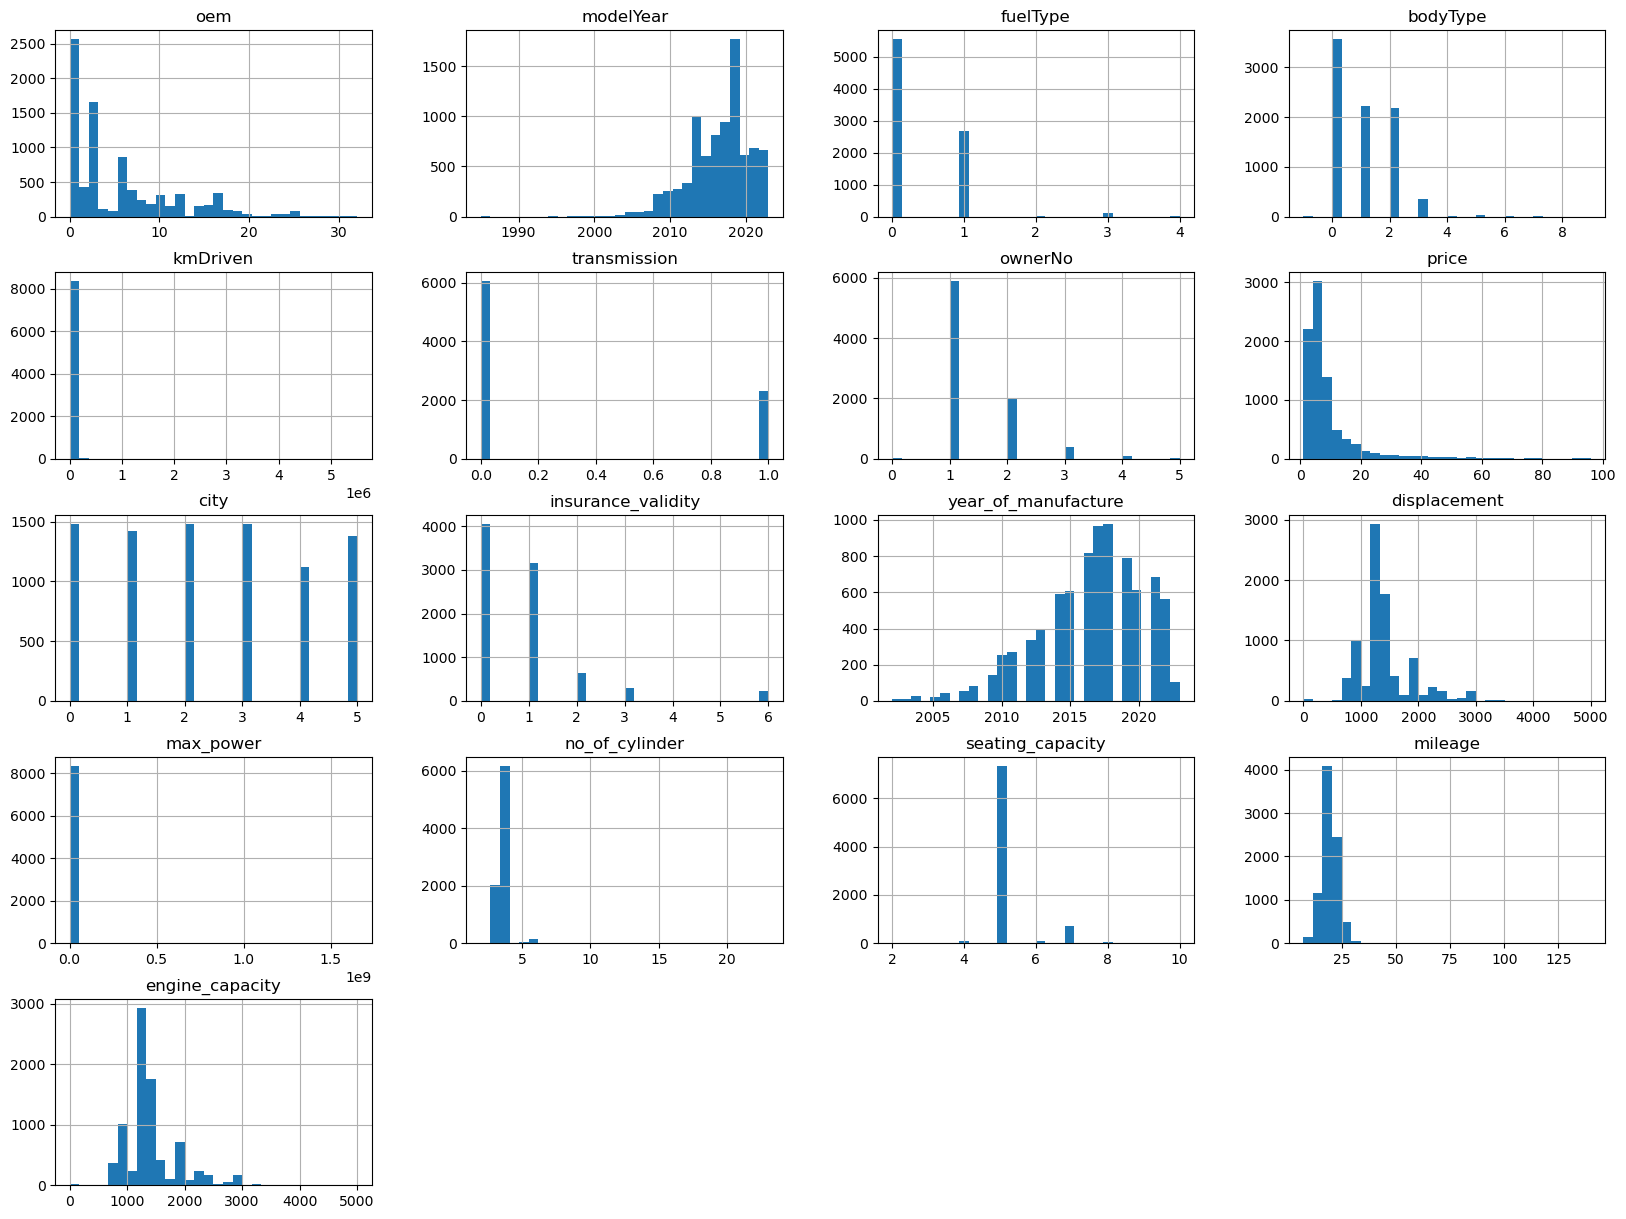

In [59]:
import matplotlib.pyplot as plt  
final_dataframe.hist(figsize=(20,15), bins=30)  
plt.show()


C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\3379111571.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\3379111571.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\3379111571.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
C:\Users\vanat\AppData\Local\Temp\ipykernel_21560\3379111571.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xtic

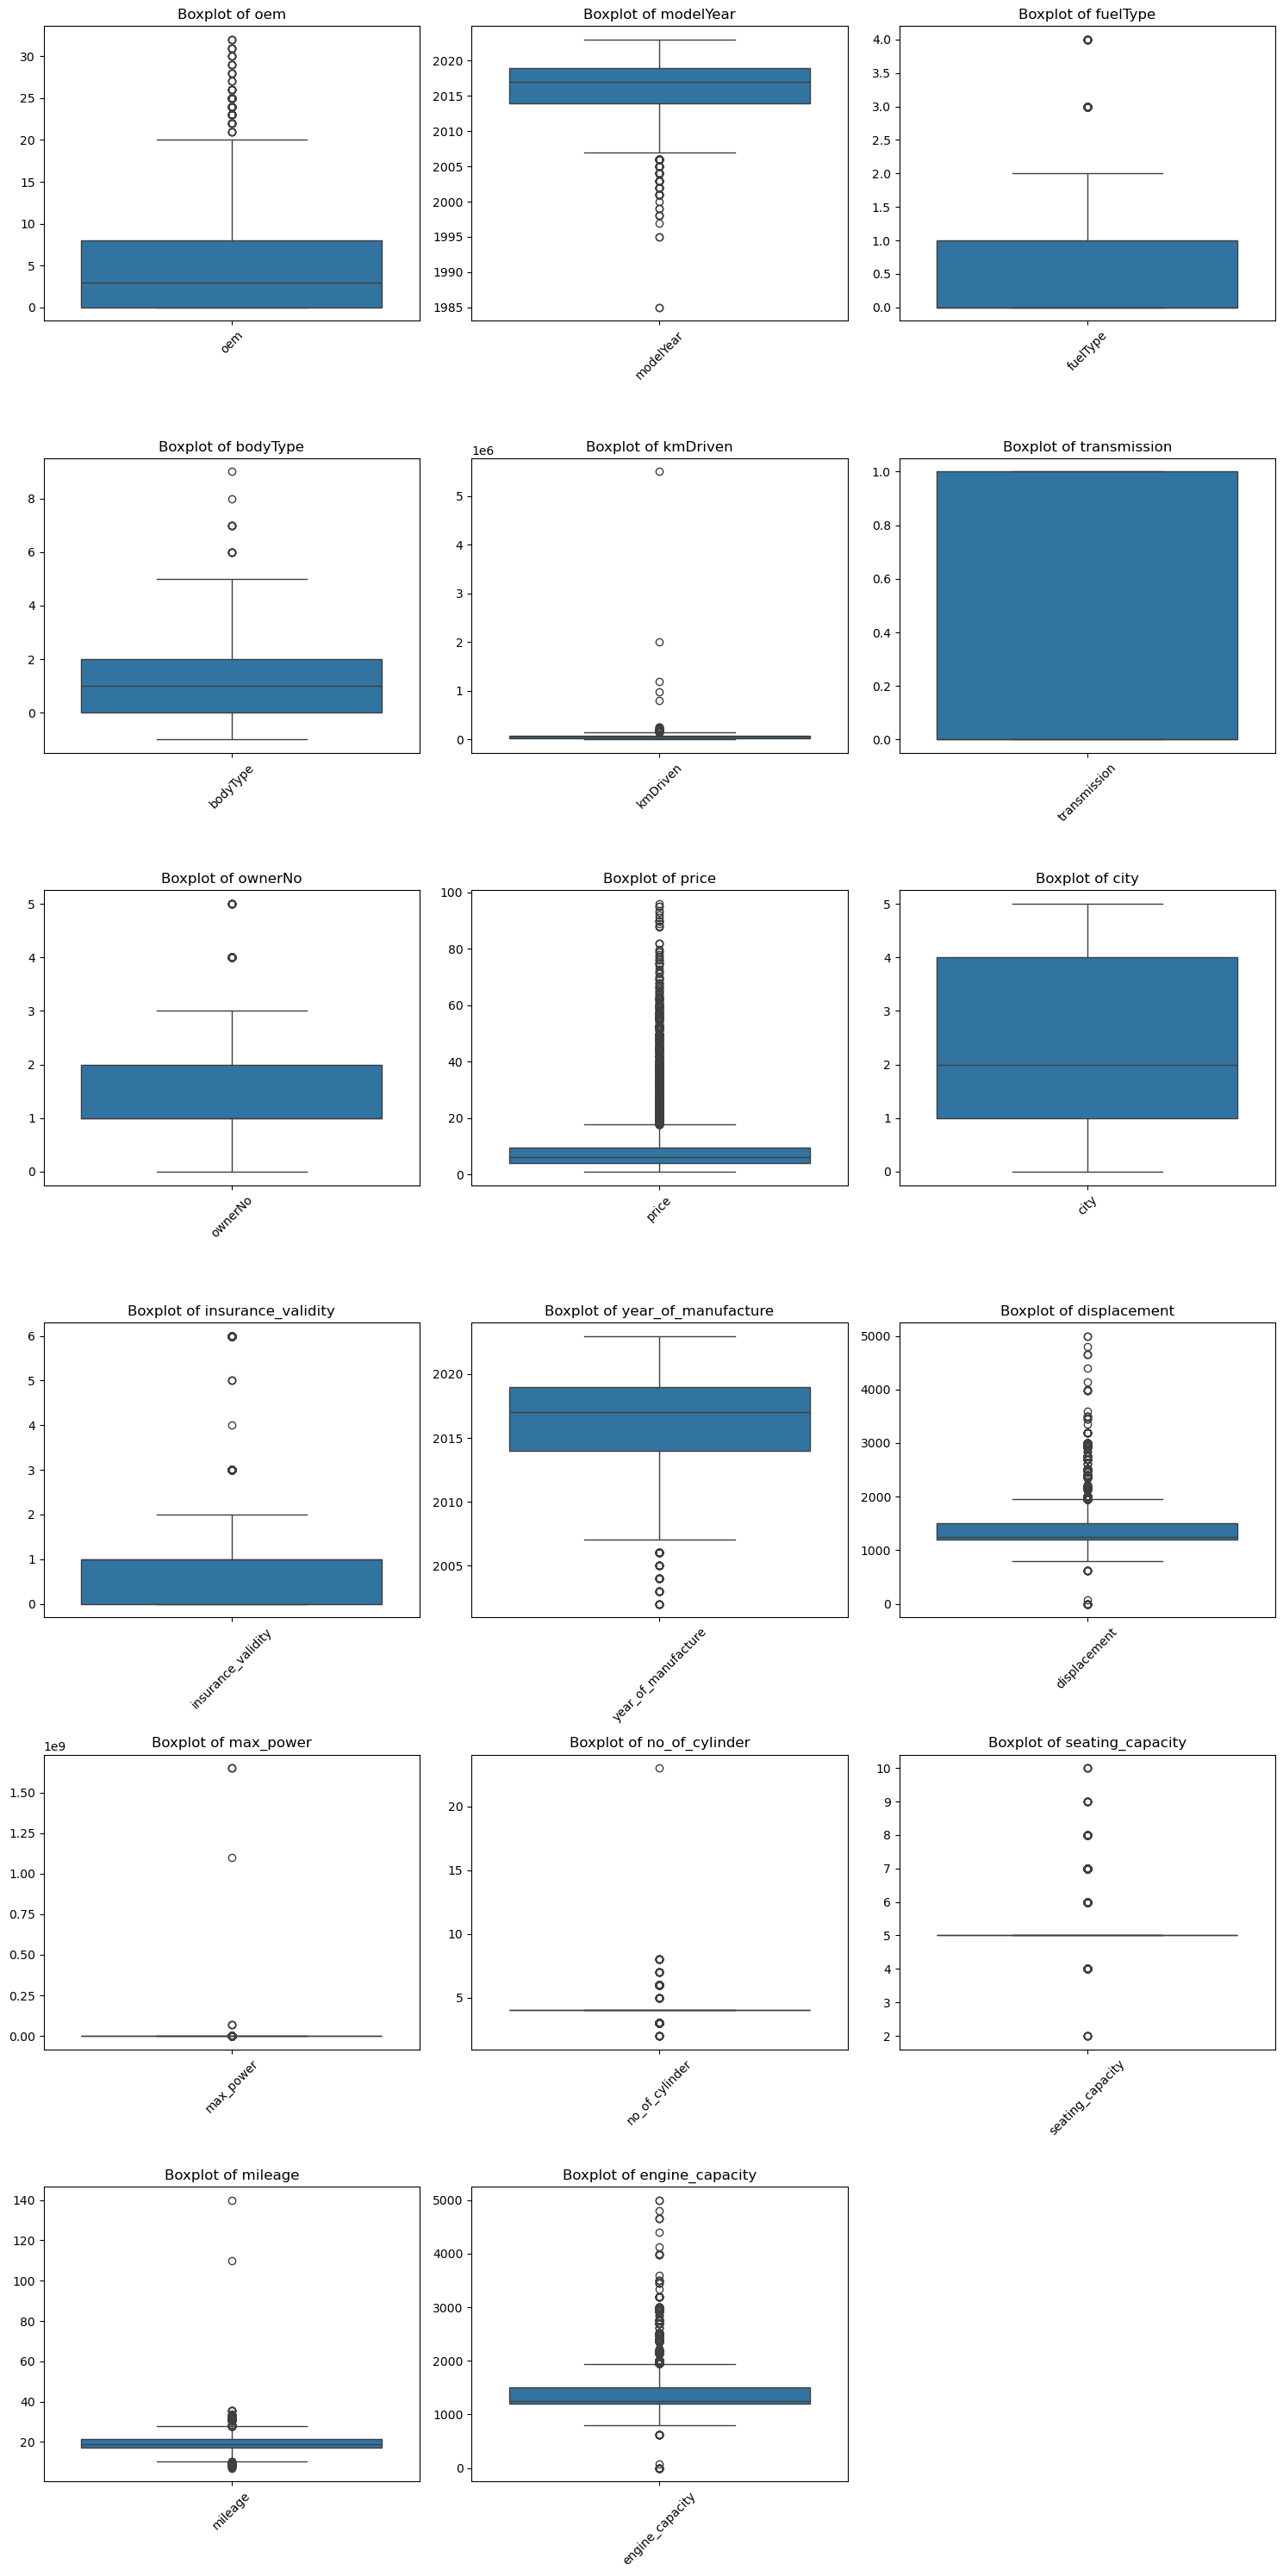

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Select numerical columns
num_columns = final_dataframe.select_dtypes(include=['int64', 'float64']).columns

# Set up the grid layout
rows = int(np.ceil(len(num_columns) / 3))  # Adjust number of rows dynamically
fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))  # 3 columns per row
axes = axes.flatten()  # Flatten in case we have fewer than 3 columns in the last row

# Loop through columns and create box plots
for i, column in enumerate(num_columns):
    sns.boxplot(data=final_dataframe[[column]], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


It has been found that there are many outliers..so handling outliers in the next step

# Handling Outliers

In [63]:
def outlier(final_dataframe,column):
  q1= final_dataframe[column].quantile(0.25)
  q3= final_dataframe[column].quantile(0.75)

  iqr= q3-q1

  upper_threshold= q3 + (1.5*iqr)
  lower_threshold= q1 - (1.5*iqr)

  final_dataframe[column]= final_dataframe[column].clip(lower_threshold, upper_threshold)

In [64]:
# Compute correlation matrix
corr_matrix = final_dataframe.corr()
threshold = 0.7

# Find pairs of correlated features (excluding self-correlation)
corr_pairs = corr_matrix.where(abs(corr_matrix) > threshold).stack().reset_index()
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Remove self-correlations (where Feature 1 == Feature 2)
corr_pairs = corr_pairs[corr_pairs["Feature 1"] != corr_pairs["Feature 2"]]

# Drop duplicate pairs (e.g., A-B and B-A)
corr_pairs = corr_pairs.drop_duplicates(subset=["Correlation"])

# Display correlated feature pairs
print(corr_pairs)


       Feature 1            Feature 2  Correlation
2      modelYear  year_of_manufacture     0.969530
14  displacement      engine_capacity     0.999997


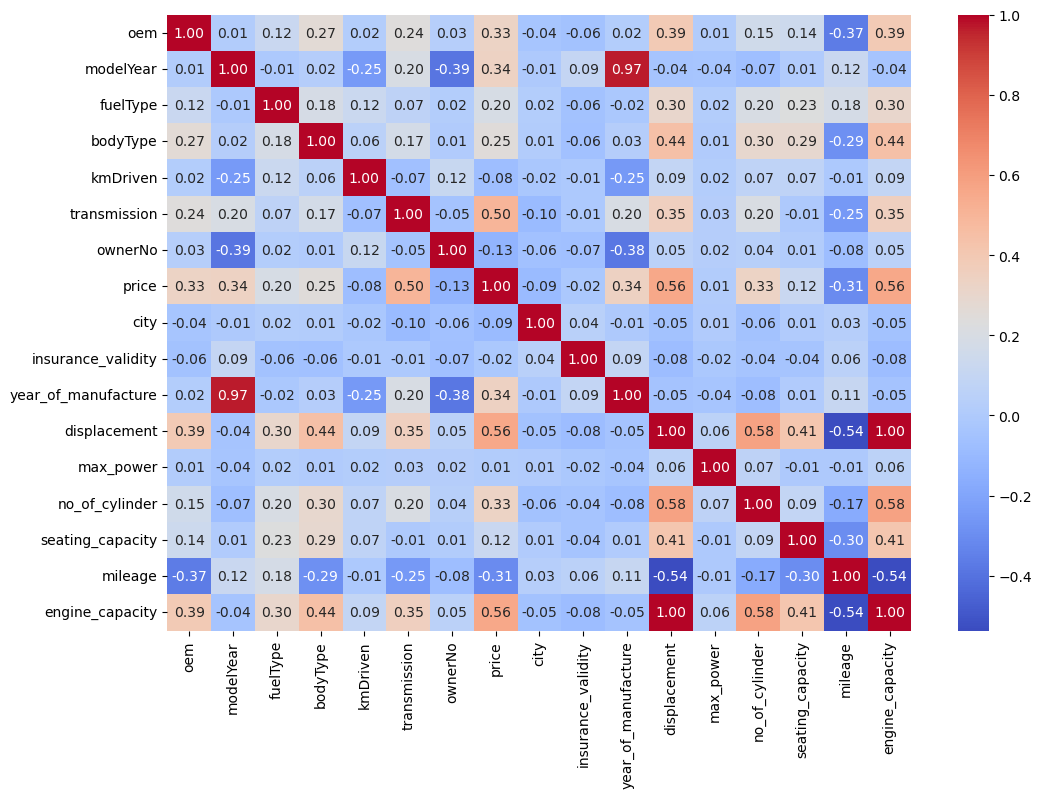

In [65]:
plt.figure(figsize=(12, 8))  
sns.heatmap(final_dataframe.corr(), annot=True, cmap='coolwarm', fmt=".2f")  
plt.show()


It has been seen that year_of_manufacture and modelyear and engine_capacity and displacement are higly correlated..so there might be same datas inside.
so checking it and retaining only one of those..if they resemble the same content.

In [67]:
same_values = (final_dataframe['modelYear'] == final_dataframe['year_of_manufacture']).all()
print(f"Are all values identical? {same_values}")


Are all values identical? False


In [68]:
final_dataframe['diff'] = final_dataframe['modelYear'] - final_dataframe['year_of_manufacture']
print(final_dataframe['diff'].value_counts())


diff
 0.0     8349
-16.0       9
-19.0       3
-22.0       2
-32.0       2
-18.0       2
-17.0       1
-20.0       1
Name: count, dtype: int64


In [69]:
final_dataframe = final_dataframe.drop(columns=['year_of_manufacture','displacement','diff'])

In [70]:
final_dataframe.head(2)

,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,price,city,insurance_validity,max_power,no_of_cylinder,seating_capacity,mileage,engine_capacity
0,0,2015,0,0,120000,0,3,4.00,0,0,67.04,3.0,5.0,23.1,998.0
1,1,2018,0,1,32706,0,2,8.11,0,1,121.31,3.0,5.0,17.0,1497.0


In [71]:
# Calculate skewness for all columns
skewness = final_dataframe.skew()

# Display skewness values
print(skewness)


oem                    1.330077
modelYear             -0.911899
fuelType               2.076371
bodyType               0.941718
kmDriven              50.392530
transmission           0.997599
ownerNo                1.898179
price                  3.691507
city                   0.085161
insurance_validity     2.624063
max_power             47.049924
no_of_cylinder         4.978941
seating_capacity       2.590518
mileage                4.953728
engine_capacity        1.615777
dtype: float64


## Applying Log Transformation for highly skewed features

In [73]:
# Applying log transformation
final_dataframe["kmDriven"] = np.log1p(final_dataframe["kmDriven"])
final_dataframe["max_power"] = np.log1p(final_dataframe["max_power"])
final_dataframe["no_of_cylinder"] = np.log1p(final_dataframe["no_of_cylinder"])


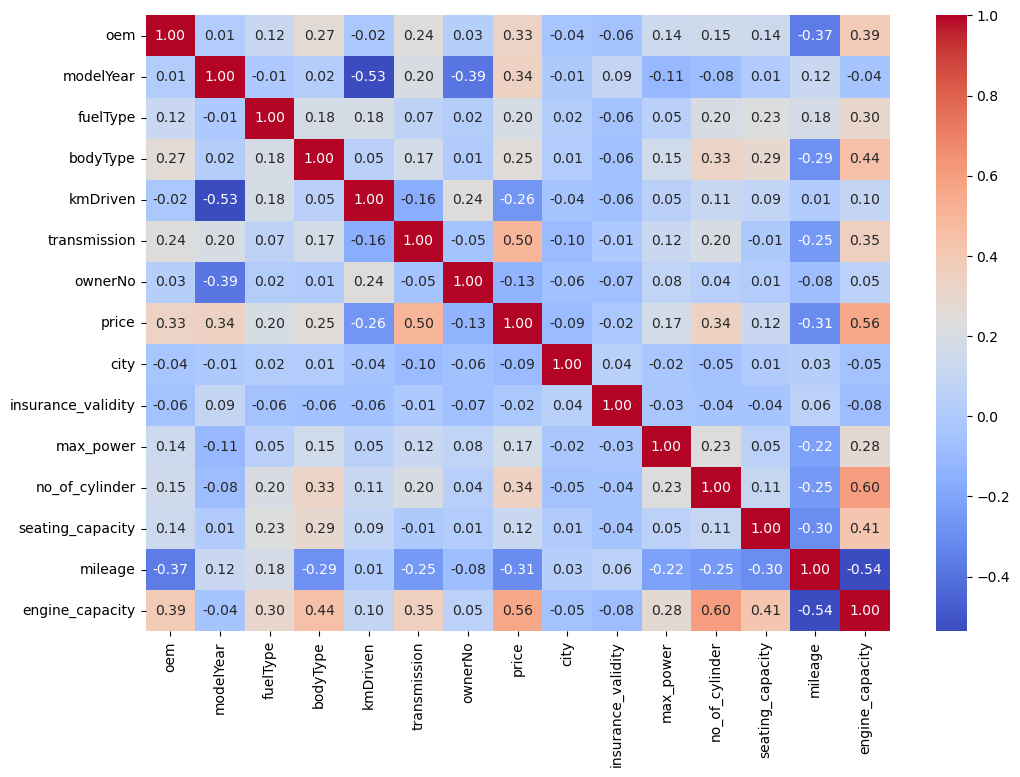

In [74]:
plt.figure(figsize=(12, 8))  
sns.heatmap(final_dataframe.corr(), annot=True, cmap='coolwarm', fmt=".2f")  
plt.show()


In [75]:
X=final_dataframe.drop(columns=['price'])
Y=final_dataframe['price']

In [76]:
X.head()

,oem,modelYear,fuelType,bodyType,kmDriven,transmission,ownerNo,city,insurance_validity,max_power,no_of_cylinder,seating_capacity,mileage,engine_capacity
0,0,2015,0,0,11.695255,0,3,0,0,4.220096,1.386294,5.0,23.10,998.0
1,1,2018,0,1,10.395344,0,2,0,1,4.806559,1.386294,5.0,17.00,1497.0
2,2,2018,0,0,9.388487,0,1,0,1,4.442651,1.386294,5.0,23.84,1199.0
3,3,2014,0,2,9.786673,0,1,0,1,4.417152,1.609438,5.0,19.10,1197.0
4,0,2015,1,1,11.002117,0,1,0,0,4.494239,1.609438,5.0,23.65,1248.0


In [77]:
Y

0       4.00
1       8.11
2       5.85
3       4.62
4       7.90
        ... 
8364    5.10
8365    1.80
8366    5.50
8367    1.40
8368    5.00
Name: price, Length: 8369, dtype: float64

# Model preparation

In [79]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##train and test data split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)



In [80]:
# Define models for training and cross-validation
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}



## Cross-validation

In [82]:
# Cross-validation and performance evaluation on training data
cv_results = {
    'Model': [],
    'Mean CV MAE': [],
    'Mean CV MSE': [],
    'Mean CV R²': []
}

# cross-validation for each model
for model_name, model in models.items():
    print(f"Evaluating {model_name} with cross-validation...")

    # cross-validation
    cv_mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_mse = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Store the results
    cv_results['Model'].append(model_name)
    cv_results['Mean CV MAE'].append(np.mean(-cv_mae))
    cv_results['Mean CV MSE'].append(np.mean(-cv_mse))
    cv_results['Mean CV R²'].append(np.mean(cv_r2))

# Create a DataFrame to summarize cross-validation results
cv_results_df = pd.DataFrame(cv_results)
print("Cross-Validation Results:")
print(cv_results_df)

Evaluating Linear Regression with cross-validation...
Evaluating Decision Tree with cross-validation...
Evaluating Random Forest with cross-validation...
Evaluating Gradient Boosting with cross-validation...
Evaluating Lasso with cross-validation...
Evaluating Ridge with cross-validation...
Cross-Validation Results:
               Model  Mean CV MAE  Mean CV MSE  Mean CV R²
0  Linear Regression     3.982465    47.644414    0.550320
1      Decision Tree     1.834204    27.794481    0.733485
2      Random Forest     1.409718    14.133215    0.865500
3  Gradient Boosting     1.756804    17.309108    0.834513
4              Lasso     4.094913    56.049804    0.471296
5              Ridge     3.982124    47.643616    0.550330


## Hyperparameter tunning

In [84]:
# Define hyperparameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]},
    
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]},
    
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 10]},
    
    'Lasso': {
        'alpha': [0.01, 0.1, 1]},
    
    'Ridge': {
        'alpha': [0.01, 0.1, 1]}}

In [85]:

# Hyperparameter tuning for each model
best_models = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    
    # Perform grid search
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    
    # Save the best model and parameters
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

# Model Evaluation and Comparison
results = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'R²': []}


Tuning Linear Regression...
Best Parameters for Linear Regression: {}
Tuning Decision Tree...
Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Tuning Random Forest...
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Tuning Gradient Boosting...
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Tuning Lasso...
Best Parameters for Lasso: {'alpha': 0.1}
Tuning Ridge...
Best Parameters for Ridge: {'alpha': 1}


## Model Evaluation

In [87]:
# Evaluate best models on the test set
for model_name, model in best_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results for comparison
    results['Model'].append(model_name)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['R²'].append(r2)


In [88]:
# DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("Model Evaluation Results:")
print(results_df)

# Selecting the best model based on R² or lowest MAE/MSE
best_model = results_df.loc[results_df['R²'].idxmax()]  # Or idxmin() for MAE/MSE
print(f"Best Model: {best_model['Model']}")

Model Evaluation Results:
               Model       MAE        MSE        R²
0  Linear Regression  4.244873  64.778005  0.516446
1      Decision Tree  1.802345  22.846756  0.829454
2      Random Forest  1.450733  15.670784  0.883021
3  Gradient Boosting  1.429377  15.306168  0.885743
4              Lasso  4.210151  65.519953  0.510907
5              Ridge  4.244720  64.781067  0.516423
Best Model: Gradient Boosting


In [89]:
import pickle
best_model = best_models['Gradient Boosting']
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Gradient Boosting model saved successfully!")

Gradient Boosting model saved successfully!


## Model prediction

In [91]:
# Predicting using the best Gradient Boosting model
best_model.fit(X_train, y_train)

# predictions on the test set
y_pred = best_model.predict(X_test)

# Display the predictions
print(f"Predicted Prices (first 5 examples): {y_pred[:5]}")

Predicted Prices (first 5 examples): [8.41010224 2.49062679 3.2660506  6.46910097 9.98986603]
